In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
from keras import models
from keras.utils import plot_model
from utils.data_utils import ClassificationDataSeq, prepare_data_df
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
data = pd.read_csv('../data/train.csv')
data = prepare_data_df(data)
data, _ = train_test_split(data, test_size=0.2, random_state=42)
data.head()

,image_id,defect_1,defect_2,defect_3,defect_4,defect_count,has_defect_1,has_defect_2,has_defect_3,has_defect_4
11056,e03364e95.jpg,,,,,0,0,0,0,0
10807,db62a970a.jpg,,,,308600 2 308852 6 309105 10 309359 12 309614 1...,1,0,0,0,1
10765,da691bc2e.jpg,,,11454 2 11707 5 11960 9 12214 11 12467 15 1272...,,1,0,0,1,0
6422,823994b16.jpg,,,157194 5 157450 13 157706 21 157962 28 158218 ...,,1,0,0,1,0
5340,6c011fc34.jpg,73920 7 74163 20 74241 37 74407 32 74497 37 74...,,111041 4 111291 10 111541 16 111794 19 112050 ...,,2,1,0,1,0


Instructions for updating:
Colocations handled automatically by placer.


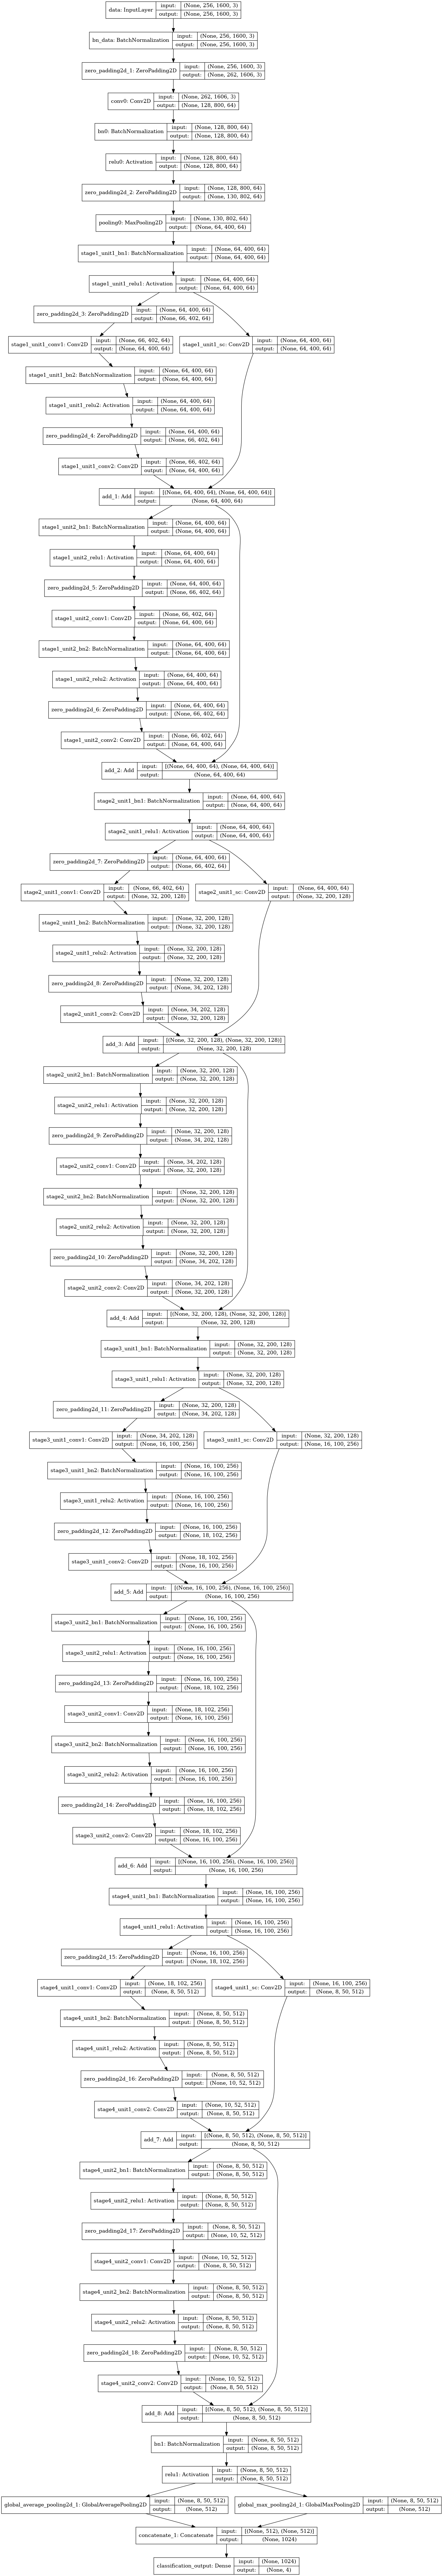

In [5]:
model = models.load_model('models/cfn_model_best.h5', compile=False)
plot_model(model, to_file='gi_model.png', show_shapes=True)

In [6]:
data_seq = ClassificationDataSeq(42, data, 12, (256, 1600, 3), '../data/train_images')
preds = model.predict_generator(data_seq, verbose=1)
preds.shape, preds[:5]

838/838 [==============================] - 187s 224ms/step


((10054, 4),
 array([[4.0793419e-04, 2.1278858e-05, 1.6659498e-05, 0.0000000e+00],
        [3.6358833e-06, 1.9341707e-05, 4.6234512e-01, 9.9987495e-01],
        [2.6375055e-05, 1.1026859e-06, 9.9938589e-01, 4.0104985e-04],
        [9.8347664e-06, 1.4483929e-05, 9.9998629e-01, 1.8775463e-06],
        [9.9988937e-01, 2.8818846e-05, 3.0970973e-01, 6.9439411e-06]],
       dtype=float32))

In [7]:
true_data = data[['image_id', 'has_defect_1', 'has_defect_2', 'has_defect_3', 'has_defect_4']]
true_data.head()

,image_id,has_defect_1,has_defect_2,has_defect_3,has_defect_4
11056,e03364e95.jpg,0,0,0,0
10807,db62a970a.jpg,0,0,0,1
10765,da691bc2e.jpg,0,0,1,0
6422,823994b16.jpg,0,0,1,0
5340,6c011fc34.jpg,1,0,1,0


In [8]:
pred_data = true_data.copy()
pred_data[['has_defect_1', 'has_defect_2', 'has_defect_3', 'has_defect_4']] = preds.round().astype(np.int8)
pred_data.head()

,image_id,has_defect_1,has_defect_2,has_defect_3,has_defect_4
11056,e03364e95.jpg,0,0,0,0
10807,db62a970a.jpg,0,0,0,1
10765,da691bc2e.jpg,0,0,1,0
6422,823994b16.jpg,0,0,1,0
5340,6c011fc34.jpg,1,0,0,0


In [9]:
from sklearn.metrics import multilabel_confusion_matrix

In [10]:
true_data[true_data.columns[1:]].values, pred_data[pred_data.columns[1:]].values

(array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int8), array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]))

In [11]:
mcm = multilabel_confusion_matrix(true_data[true_data.columns[1:]].values, pred_data[pred_data.columns[1:]].values)
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
tn, tp, fn, fp

(array([9297, 9840, 5839, 9406]),
 array([ 674,  165, 3943,  626]),
 array([ 61,  39, 165,  10]),
 array([ 22,  10, 107,  12]))

In [12]:
precision = tp / (tp+fp)
recall = tp / (tp + fn)
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1-score: {2*precision*recall / (precision + recall)}')

precision: [0.9683908  0.94285714 0.97358025 0.98119122]
recall: [0.9170068  0.80882353 0.95983447 0.98427673]
f1-score: [0.9419986  0.8707124  0.96665849 0.98273155]


In [13]:
data['is_pred_wrong'] = (np.where(true_data[true_data.columns[1:]].values != pred_data[pred_data.columns[1:]].values, 1, 0).sum(axis=-1) > 0).astype(np.int8)
data[['pred_has_defect_1', 'pred_has_defect_2', 'pred_has_defect_3', 'pred_has_defect_4']] = pred_data[pred_data.columns[1:]]
data.tail()

,image_id,defect_1,defect_2,defect_3,defect_4,defect_count,has_defect_1,has_defect_2,has_defect_3,has_defect_4,is_pred_wrong,pred_has_defect_1,pred_has_defect_2,pred_has_defect_3,pred_has_defect_4
11964,f3862285d.jpg,69862 20 70098 40 70354 40 70610 40 70866 40 7...,,,,1,1,0,0,0,0,1,0,0,0
5191,6951354ff.jpg,,,,,0,0,0,0,0,0,0,0,0,0
5390,6cf49f691.jpg,,,,,0,0,0,0,0,0,0,0,0,0
860,11b1e2910.jpg,,,,,0,0,0,0,0,0,0,0,0,0
7270,93c5acf9d.jpg,,,,,0,0,0,0,0,0,0,0,0,0


In [14]:
data[data.is_pred_wrong == 1]

,image_id,defect_1,defect_2,defect_3,defect_4,defect_count,has_defect_1,has_defect_2,has_defect_3,has_defect_4,is_pred_wrong,pred_has_defect_1,pred_has_defect_2,pred_has_defect_3,pred_has_defect_4
5340,6c011fc34.jpg,73920 7 74163 20 74241 37 74407 32 74497 37 74...,,111041 4 111291 10 111541 16 111794 19 112050 ...,,2,1,0,1,0,1,1,0,0,0
6984,8ddf889d8.jpg,,,366820 27 367052 51 367308 51 367564 51 367821...,,1,0,0,1,0,1,0,0,0,0
7049,8f0a7e8af.jpg,37498 17 37552 13 37738 43 37793 34 37870 7 37...,,199514 2 199769 3 200024 3 200279 4 200534 5 2...,,2,1,0,1,0,1,0,0,1,0
11651,ec921fcc7.jpg,,,158452 3 158704 7 158956 11 159208 15 159461 1...,,1,0,0,1,0,1,0,0,0,0
9839,c7b4afcee.jpg,,,,,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5618,71553a0d8.jpg,,,41762 59 42014 63 42267 66 42519 70 42772 73 4...,174378 7 174632 20 174886 33 175140 46 175394 ...,2,0,0,1,1,1,0,0,0,1
5258,6a9ff4b0c.jpg,,17153 179 17409 179 17665 179 17921 179 18177 ...,,,1,0,1,0,0,1,0,0,0,0
9692,c4c5b8e2a.jpg,,,372971 19 373023 87 373215 34 373250 255 37350...,,1,0,0,1,0,1,0,0,0,0
10253,cff20dde9.jpg,,,42113 128 42242 255 42498 255 42754 255 43010 ...,,1,0,0,1,0,1,0,0,0,0


In [30]:
data[data.is_pred_wrong == 1][data.columns[:10]].to_csv('gi_cfn_failed_preds.csv', index=False)

In [16]:
print(f'{data[data.has_defect_1 != data.pred_has_defect_1].image_id.count() * 100 / data.has_defect_1.count():.4f}% defect 1 predicted wrong')
print(f'{data[data.has_defect_2 != data.pred_has_defect_2].image_id.count() * 100 / data.has_defect_2.count():.4f}% defect 2 predicted wrong')
print(f'{data[data.has_defect_3 != data.pred_has_defect_3].image_id.count() * 100 / data.has_defect_3.count():.4f}% defect 3 predicted wrong')
print(f'{data[data.has_defect_4 != data.pred_has_defect_4].image_id.count() * 100 / data.has_defect_4.count():.4f}% defect 4 predicted wrong')

0.8255% defect 1 predicted wrong
0.4874% defect 2 predicted wrong
2.7054% defect 3 predicted wrong
0.2188% defect 4 predicted wrong


In [17]:
print('number of time defect 1 is detected incorrectly')
data[data.has_defect_1 != data.pred_has_defect_1][data.columns[-4:]].sum()

number of time defect 1 is detected incorrectly


pred_has_defect_1    22
pred_has_defect_2    10
pred_has_defect_3    25
pred_has_defect_4     3
dtype: int64

In [18]:
print('number of time defect 2 is detected incorrectly')
data[data.has_defect_2 != data.pred_has_defect_2][data.columns[-4:]].sum()

number of time defect 2 is detected incorrectly


pred_has_defect_1    15
pred_has_defect_2    10
pred_has_defect_3     9
pred_has_defect_4     2
dtype: int64

In [19]:
print('number of time defect 3 is detected incorrectly')
data[data.has_defect_3 != data.pred_has_defect_3][data.columns[-4:]].sum()

number of time defect 3 is detected incorrectly


pred_has_defect_1     50
pred_has_defect_2      9
pred_has_defect_3    107
pred_has_defect_4     74
dtype: int64

In [20]:
print('number of time defect 4 is detected incorrectly')
data[data.has_defect_4 != data.pred_has_defect_4][data.columns[-4:]].sum()

number of time defect 4 is detected incorrectly


pred_has_defect_1     0
pred_has_defect_2     0
pred_has_defect_3    14
pred_has_defect_4    12
dtype: int64

In [21]:
print(f'no. of times 0 predicted as 1: {data[data.defect_count == 0][data.pred_has_defect_1 == 1].shape[0]}')
print(f'no. of times 0 predicted as 2: {data[data.defect_count == 0][data.pred_has_defect_2 == 1].shape[0]}')
print(f'no. of times 0 predicted as 3: {data[data.defect_count == 0][data.pred_has_defect_3 == 1].shape[0]}')
print(f'no. of times 0 predicted as 4: {data[data.defect_count == 0][data.pred_has_defect_4 == 1].shape[0]}')

no. of times 0 predicted as 1: 5
no. of times 0 predicted as 2: 4
no. of times 0 predicted as 3: 48
no. of times 0 predicted as 4: 4


/home/ashwanipandey/miniconda3/envs/mldl_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/ashwanipandey/miniconda3/envs/mldl_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/ashwanipandey/miniconda3/envs/mldl_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ashwanipandey/miniconda3/envs/mldl_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [22]:
data[data.defect_count == 0].shape, data[data.has_defect_1 == 1].shape, data[data.has_defect_2 == 1].shape, data[data.has_defect_3 == 1].shape, data[data.has_defect_4 == 1].shape

((4724, 15), (735, 15), (204, 15), (4108, 15), (636, 15))

In [26]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

/home/ashwanipandey/miniconda3/envs/mldl_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


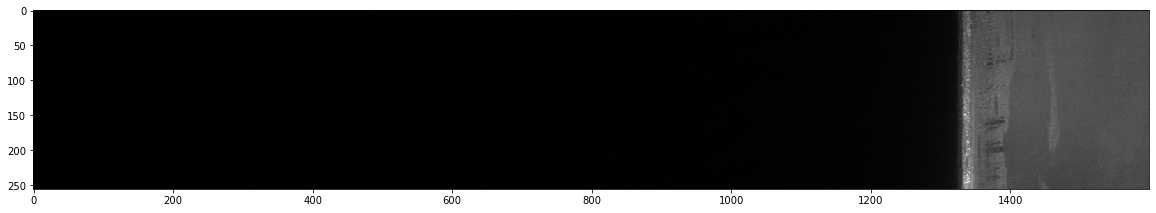

In [27]:
img_id = data[data.defect_count == 0][data.pred_has_defect_1==1].iloc[4].image_id
img = cv2.imread(f'../data/train_images/{img_id}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)